In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2.8.2
Num GPUs Available:  1


# Load CIFAR10

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(X_train.shape, y_train.shape)

170508288/170498071 [==============================] - 13s 0us/step
(50000, 32, 32, 3) (50000, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


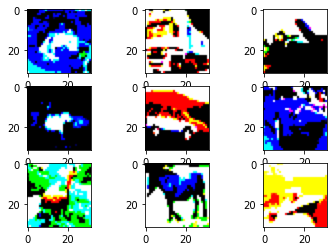

In [14]:
from matplotlib import pyplot
import numpy as np

# create a grid of 3x3 images
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

## Preprocessing

In [3]:
# Adequate your image to the format the model requires
X_train = keras.applications.resnet50.preprocess_input(X_train)
X_test = keras.applications.resnet50.preprocess_input(X_test)

# One-hot
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# Model with trained weights
Imagenet and ResNet50

https://keras.io/api/applications/

In [4]:
#  include_top=False -> removing the last dense layers
# input = keras.Input(shape=(32, 32, 3))

res_model = keras.applications.ResNet50(
    include_top = False,
    weights = "imagenet",
    # input_tensor = input
)

94781440/94765736 [==============================] - 0s 0us/step


# Approaches in Transfer Learning
- Feature Extraction
- Fine tuning

In [ ]:
# res_model.layers

Freeze all layers except for tha last block of ResNet50.

This ensures that the model does not learn the weights again, saving us a lot of time and space complexity.

In [5]:
for layer in res_model.layers[:143]:
    layer.trainable = False

In [6]:
for i, layer in enumerate(res_model.layers[140:]):
    print(i+140, layer.name, " - ", layer.trainable)

140 conv4_block6_3_bn  -  False
141 conv4_block6_add  -  False
142 conv4_block6_out  -  False
143 conv5_block1_1_conv  -  True
144 conv5_block1_1_bn  -  True
145 conv5_block1_1_relu  -  True
146 conv5_block1_2_conv  -  True
147 conv5_block1_2_bn  -  True
148 conv5_block1_2_relu  -  True
149 conv5_block1_0_conv  -  True
150 conv5_block1_3_conv  -  True
151 conv5_block1_0_bn  -  True
152 conv5_block1_3_bn  -  True
153 conv5_block1_add  -  True
154 conv5_block1_out  -  True
155 conv5_block2_1_conv  -  True
156 conv5_block2_1_bn  -  True
157 conv5_block2_1_relu  -  True
158 conv5_block2_2_conv  -  True
159 conv5_block2_2_bn  -  True
160 conv5_block2_2_relu  -  True
161 conv5_block2_3_conv  -  True
162 conv5_block2_3_bn  -  True
163 conv5_block2_add  -  True
164 conv5_block2_out  -  True
165 conv5_block3_1_conv  -  True
166 conv5_block3_1_bn  -  True
167 conv5_block3_1_relu  -  True
168 conv5_block3_2_conv  -  True
169 conv5_block3_2_bn  -  True
170 conv5_block3_2_relu  -  True
171 conv5_bl

# Create a model and connect to the pretrained model

In [ ]:
# model  = keras.models.Sequential()
# model.add(res_model)
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(10, activation = "softmax"))

In [7]:
# size of ResNet model
to_res = (224, 224)

model = keras.models.Sequential()
model.add(keras.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(res_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation='softmax'))

### Callbacks:
we can use callbacks in our model to perform certain actions in the training such as weight saving.

In [8]:
check_point = keras.callbacks.ModelCheckpoint(
    filepath="cifar10.h5",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

### Model Compilation

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [10]:
# model.summary()

### Train model

In [12]:
history = model.fit(
    X_train, y_train, batch_size = 32, epochs = 5, verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[check_point]
)

Epoch 1/5
1563/1563 [==============================] - 245s 157ms/step - loss: 0.8843 - accuracy: 0.7301 - val_loss: 0.3334 - val_accuracy: 0.8906
Epoch 2/5
1563/1563 [==============================] - 230s 147ms/step - loss: 0.5108 - accuracy: 0.8556 - val_loss: 0.2922 - val_accuracy: 0.9058
Epoch 3/5
1563/1563 [==============================] - 230s 147ms/step - loss: 0.4055 - accuracy: 0.8863 - val_loss: 0.2574 - val_accuracy: 0.9185
Epoch 4/5
1563/1563 [==============================] - 244s 156ms/step - loss: 0.3291 - accuracy: 0.9090 - val_loss: 0.2351 - val_accuracy: 0.9264
Epoch 5/5
1563/1563 [==============================] - 231s 148ms/step - loss: 0.2743 - accuracy: 0.9240 - val_loss: 0.2334 - val_accuracy: 0.9266


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


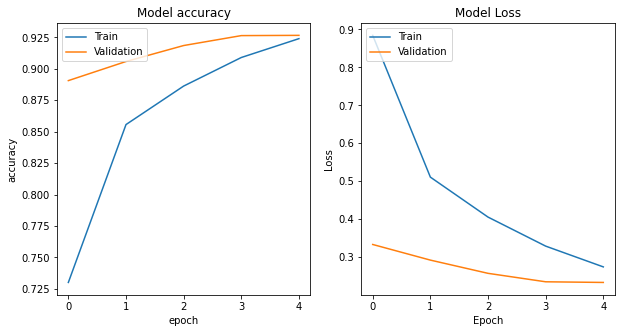

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

print(history.history.keys())
plot_history(history)

# Conclusion

- We can see ResNet50 works best with input images of 224x224.
- When using freezing on the pretrained model continues it reduces computation time, **reduces overffiting but lowers accuracy**. 
- When the new dataset is very different from the datased used for training it may be necessary to use more layer for adjustment (fine-tunning)
